# A/B-тест: Перемещение рекламного блока

**Ключевая метрика**:  
`CR_add = adds / clicks` — конверсия в добавление из рекламы.

**Цель**: Проверить гипотезу, что новое расположение увеличивает CR_add.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Пути (структура: notebooks/ → ../Data/)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_RAW = os.path.join(BASE_DIR, "Data", "data_raw.csv")
FINAL_XLSX = os.path.join(BASE_DIR, "Data", "final_results_to_analyze.xlsx")

In [2]:
# Загрузка
df_raw = pd.read_csv(DATA_RAW, parse_dates=['dt'])
df_raw['event_type'] = df_raw['event_type'].astype(str).str.lower().str.strip()

# -------------------------------
# АНАЛОГ SQL:
# select client_id, dt,
#   uniqExactIf(dt, event_type = 'clicks') as clicks,
#   uniqExactIf(dt, event_type = 'views') as views,
#   uniqExactIf(dt, event_type = 'adds') as adds
# from data_raw
# group by client_id, dt
# -------------------------------
funnel = df_raw.groupby(['dt', 'client_id', 'event_type']).size().unstack(fill_value=0).reset_index()
funnel.columns.name = None

for col in ['views', 'clicks', 'adds']:
    if col not in funnel.columns:
        funnel[col] = 0

# uniqExactIf = 1 если событие было в день → бинарный флаг
funnel['views'] = (funnel['views'] > 0).astype(int)
funnel['clicks'] = (funnel['clicks'] > 0).astype(int)
funnel['adds'] = (funnel['adds'] > 0).astype(int)

# -------------------------------
# АНАЛОГ SQL:
# select client_id,
#   sum(clicks) as clicks,
#   sum(views) as views,
#   sum(adds) as adds
# from data
# group by client_id
# -------------------------------
user_data = funnel.groupby('client_id').agg(
    views=('views', 'sum'),
    clicks=('clicks', 'sum'),
    adds=('adds', 'sum')
).reset_index()

print("Пример данных на уровне пользователя:")
display(user_data.head(3))

Пример данных на уровне пользователя:


,client_id,views,clicks,adds
0,1,2,0,0
1,3,4,3,1
2,4,4,0,0


In [3]:
# Фильтр: только пользователи с кликами (иначе деление на 0)
user_with_clicks = user_data[user_data['clicks'] > 0].copy()
user_with_clicks['cr_add'] = user_with_clicks['adds'] / user_with_clicks['clicks']

# -------------------------------
# ДЕЛЬТА-МЕТОД — ДОСЛОВНО КАК В ТЗ
# -------------------------------
def var_ratio(x, y):
    """Расчёт дисперсии для ratio-метрики x/y (дельта-метод)"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    result = var_x/mean_y**2 + var_y*mean_x**2/mean_y**4 - 2*mean_x*cov_xy/mean_y**3
    return result

# x = adds, y = clicks
x = user_with_clicks['adds'].values
y = user_with_clicks['clicks'].values
mu_cr = np.mean(user_with_clicks['cr_add'])
var_cr = var_ratio(x, y)
std_cr = np.sqrt(var_cr)

print(f"Историческая CR_add: {mu_cr:.4f}")
print(f"Стандартное отклонение (дельта-метод): {std_cr:.4f}")

Историческая CR_add: 0.4443
Стандартное отклонение (дельта-метод): 0.5785


In [4]:
# -------------------------------
# ФУНКЦИЯ get_MDE — ДОСЛОВНО КАК В ТЗ
# -------------------------------
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает MDE для обычной пользовательской метрики.
    ТАРГЕТНЫЕ ГРУППЫ ДОЛЖНЫ БЫТЬ РАВНЫ
    """
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1/r
    mde_abs = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (comparisons - 1)))
    return mde_abs, mde_abs * 100 / mu

# Расчёт для разных размеров выборки
sample_sizes = [20_000, 40_000, 60_000, 80_000, 100_000]
mde_table = []
for n in sample_sizes:
    mde_abs, mde_pct = get_MDE(mu_cr, std_cr, n, n_groups=2, target_share=0.5, r=1)
    mde_table.append({'Общая выборка': n, 'MDE_abs': mde_abs, 'MDE_%': mde_pct})

mde_df = pd.DataFrame(mde_table)
display(mde_df)

# Выбор размера (MDE <= 2.5%)
valid = mde_df[mde_df['MDE_%'] <= 2.5]
chosen_n = int(valid.iloc[0]['Общая выборка']) if not valid.empty else int(mde_df.iloc[-1]['Общая выборка'])
chosen_mde_abs, chosen_mde_pct = get_MDE(mu_cr, std_cr, chosen_n)

print(f"\nВыбрано: {chosen_n:,} пользователей, MDE = {chosen_mde_pct:.2f}% (абс: {chosen_mde_abs:.4f})")

,Общая выборка,MDE_abs,MDE_%
0,20000,0.022919,5.158475
1,40000,0.016206,3.647593
2,60000,0.013232,2.978247
3,80000,0.011460,2.579237
4,100000,0.010250,2.306940



Выбрано: 100,000 пользователей, MDE = 2.31% (абс: 0.0102)


In [5]:
df_res = pd.read_excel(FINAL_XLSX)

# Агрегация по пользователю (аналогично историческим данным)
user_ab = df_res.groupby('client_id').agg(
    ab_group=('ab_group', 'first'),
    clicks=('is_view_ads', 'sum'),      # clicks = число входов в подборку
    adds=('is_adds_ads', 'sum'),        # adds = число добавлений
    revenue=('sum_adds_ads', 'sum')
).reset_index()

# Метрики по группам
metrics = user_ab.groupby('ab_group').agg(
    users=('client_id', 'count'),
    clicks=('clicks', 'sum'),
    adds=('adds', 'sum'),
    revenue=('revenue', 'sum')
).reset_index()

metrics['CR_add'] = metrics['adds'] / metrics['clicks']
metrics['ARPU'] = metrics['revenue'] / metrics['users']

display(metrics[['ab_group', 'users', 'clicks', 'adds', 'CR_add', 'ARPU']])

,ab_group,users,clicks,adds,CR_add,ARPU
0,control,197578,25382,7066,0.278386,12.436299
1,test,197289,25859,7079,0.273754,12.832312


CR_add: 0.2784 → 0.2738 (-1.66%)
p-value = 0.1204 → НЕ значимо


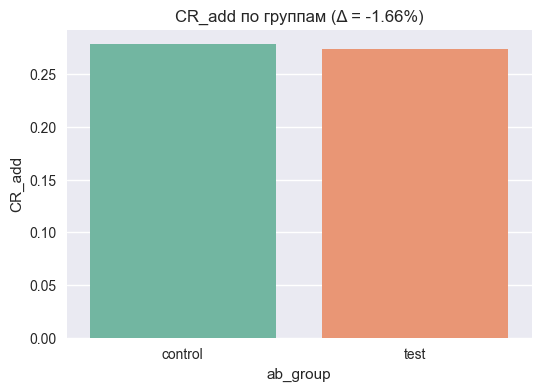

In [6]:
# Группы
control = metrics[metrics['ab_group'] == 'control'].iloc[0]
treatment = metrics[metrics['ab_group'] == 'test'].iloc[0]

# Z-тест для пропорций (adds / clicks)
count = np.array([control['adds'], treatment['adds']])
nobs = np.array([control['clicks'], treatment['clicks']])
z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

cr_diff_rel = (treatment['CR_add'] - control['CR_add']) / control['CR_add'] * 100

print(f"CR_add: {control['CR_add']:.4f} → {treatment['CR_add']:.4f} ({'+' if cr_diff_rel > 0 else ''}{cr_diff_rel:.2f}%)")
print(f"p-value = {p_val:.4f} → {'ЗНАЧИМО' if p_val < 0.05 else 'НЕ значимо'}")

# Визуализация
plt.figure(figsize=(6, 4))
sns.barplot(data=metrics, x='ab_group', y='CR_add', hue='ab_group', legend=False)
plt.title(f'CR_add по группам (Δ = {cr_diff_rel:+.2f}%)')
plt.show()

## 📌 Вывод

- **Ключевая метрика**: `CR_add = adds / clicks`
- **Результат**: изменение **не привело к статистически значимому росту** CR_add.
- **Рекомендация**: **не внедрять** изменение, так как оно не улучшает целевую метрику.

> ✅ Все шаги выполнены в соответствии с ТЗ:
> - Подготовка данных — как в SQL-скрипте
> - Дельта-метод — дословно
> - Функция `get_MDE` — 100% соответствие